#reviewData Demo
## Description
reviewData is a wrapper for [obspy](https://github.com/obspy/obspy/wiki) that reads in data from IRIS, NCEDC, sac files, or winston waveservers and allows for interactive plotting, processing, and manipulation of this data. It also allows you to find stations within a given radius that were running at a given time and attach metadata such as lat\lon, azimuth, backazimuth, and source to station distance by calling IRIS webservices or NCEDC.


The following sections describes the functions that are available and demonstrate some of the capabilities and usage


Note that this is a prototype module and is sure to have some bugs. If you encounter something that needs fixing, please contact kallstadt@usgs.gov

##Demo

The getdata function gets data from IRIS or NCEDC, if it exists, and returns data in same order as station list. The data can be saved automatically so the next time the function is called, it won't have to reload from IRIS or NCEDC. getdata_winston and getdata_sac are other options. See reviewData source code or type ? after the function in ipython for info on how to use those.

In [7]:
from reviewData import reviewData
from obspy import UTCDateTime

stations = 'JCW,B05D,MRBL'
networks = 'UW,TA'
location = '*'  #Wildcard gets all location codes
channels = 'BHZ,EHZ,HHZ' #Could also use ? wildcard like ??Z to get all vertical components
starttime = UTCDateTime(2014, 3, 22, 17, 37, 0)
endtime = UTCDateTime(2014, 3, 22, 17, 45, 0)

st = reviewData.getdata(networks, stations, location, channels, starttime, endtime, attach_response=True,
            savedat=True, folderdat='data', filenamepref='Data_', clientname='IRIS',
            loadfromfile=True, reloadfile=False)

This downloads the data from these three stations for the time span specified into the obspy stream st.

To plot this, we can call recsec, which plots a record section

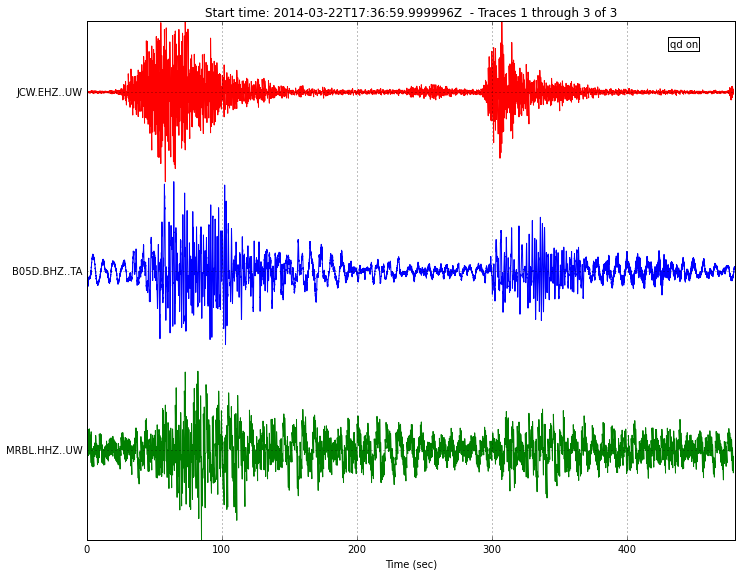

In [8]:
%matplotlib inline
fig = reviewData.recsec(st, norm=True)

We can attach the source to station distance, azimuth and backazimuth to a source. This will save rdist, baz, and az in trace.stats. The distance from the source will also then show up on the plot

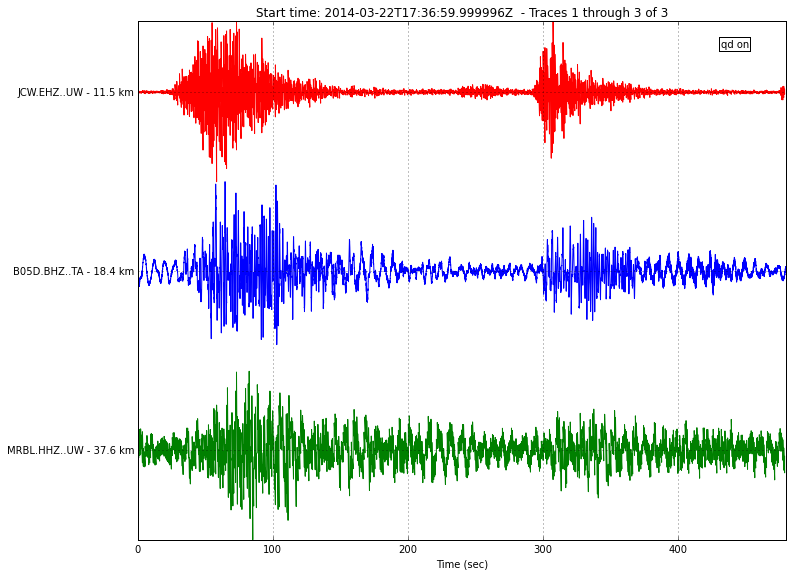

In [10]:
event_lat = 48.2852
event_lon = -121.8512

st = reviewData.attach_distaz_IRIS(st, event_lat, event_lon)
fig1 = reviewData.recsec(st, norm=True)

We could also do a station correction to get the actual ground velocities. Let's correct all stations with pre-filtering to 1-5 Hz. Note that this will only work if you requested that the station response info be attached to the data in the getdata step above (attach_response=True)

In [11]:
output = 'VEL' # Correct to velocity, output will be in m/s
pre_filt = [0.5, 1, 5, 10] #cosine filter corners in Hz - note this is acausal

st.detrend('linear') # linear detrend
st.taper(max_percentage=0.05) # apply 5% taper to ends
st.remove_response(output=output, pre_filt=pre_filt)

3 Trace(s) in Stream:
UW.JCW..EHZ  | 2014-03-22T17:36:59.999996Z - 2014-03-22T17:44:59.979996Z | 100.0 Hz, 47999 samples
TA.B05D..BHZ | 2014-03-22T17:37:00.000000Z - 2014-03-22T17:45:00.000000Z | 40.0 Hz, 19201 samples
UW.MRBL..HHZ | 2014-03-22T17:36:59.998393Z - 2014-03-22T17:44:59.998393Z | 100.0 Hz, 48001 samples

Now if we plot with non-normalized amplitudes, we can see how the signals compare to each other directly by not normalizing the signals (norm=False)

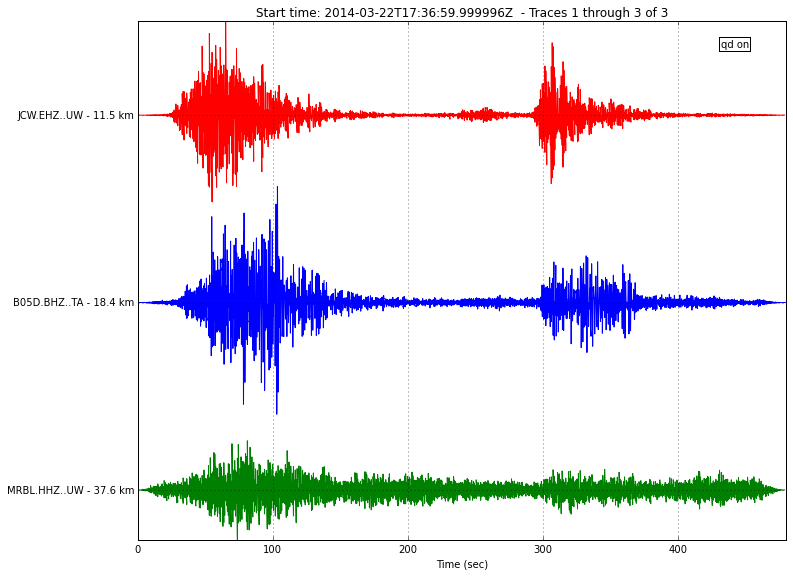

In [12]:
fig2 = reviewData.recsec(st, norm=False)

We could also make a spectrogram of these signals.

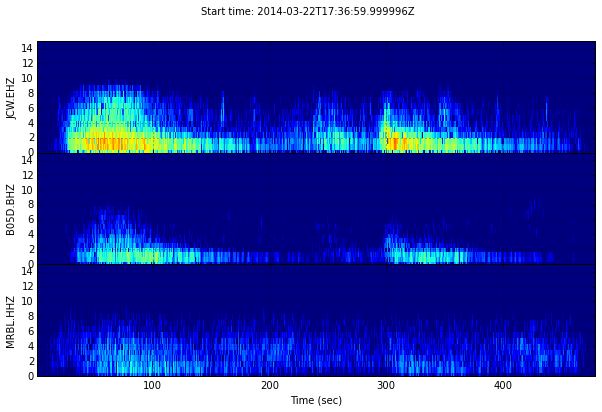

In [20]:
fig3, axes = reviewData.make_spectrogram(st, maxPower=10**-11, minPower=10**-18, freqmax=15, log1=True)

Now let's find all broadband stations that are 15 to 80 km from the source that were running when the event happened and download that data (starting 60 secs earlier than previous data grab)

In [25]:
lines, source = reviewData.get_stations_iris(event_lat, event_lon, starttime, minradiuskm=15., maxradiuskm=80., chan=('BHZ,HHZ'))
nets, stas, chans = zip(*[(line[0], line[1], line[3]) for line in lines[:-1]])  # This part should be improved to output the necessary info to begin with
st2 = reviewData.getdata(','.join(nets), ','.join(stas), '*', ','.join(chans), starttime-60., endtime, attach_response=True,
            savedat=True, clientname='IRIS',
            loadfromfile=True, reloadfile=True)

Now let's correct this broadband data to show the long period part of the signal

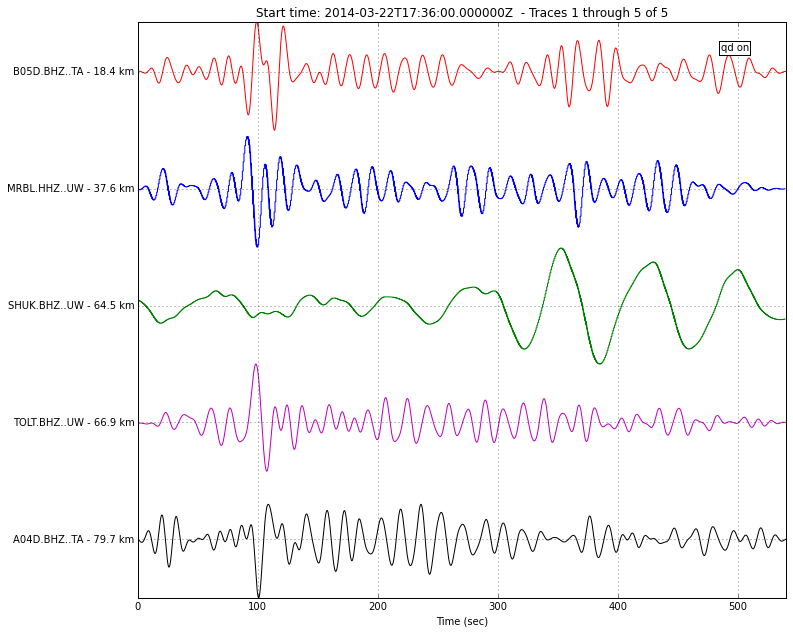

In [27]:
output = 'VEL' # Correct to velocity, output will be in m/s
pre_filt = [0.007, 0.014, 0.07, 0.13] #cosine filter corners in Hz - note this is acausal, corrects to 15 - 70 s period

st2.detrend('linear') # linear detrend
st2.taper(max_percentage=0.05) # apply 5% taper to ends
st2.remove_response(output=output, pre_filt=pre_filt)
st2 = reviewData.attach_distaz_IRIS(st2, event_lat, event_lon)

# Sort by distance to the source
st2.sort(keys=['rdist'])

fig4 = reviewData.recsec(st2, norm=True)

We can see faint long period signals associated with his event, and we can also see that SHUK is not a good signal. We also might want to make some measurements or time picks, so we can use InteractivePlot to do those things and more. This won't work in an ipython notebook, so you'll just have to try it on your own computer, for it to work, start up ipython by typing ipython --pylab. Note that if you press c and make a station correction again, your data will be messed up because you already did the station correction before starting InteractivePlot. Only do this if you are inputting raw data and have attached the response info when you requested the data.

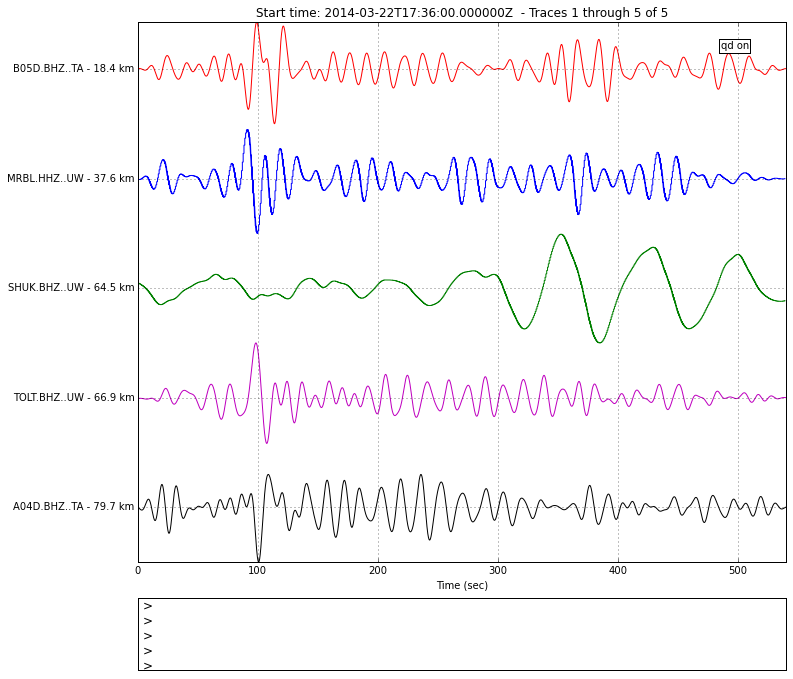


        up - double scaling
        down - half scaling
        right - move forward
        left - go back
        A - make amplitude pick
        B - box zoom
        C - station correction
        D - scroll down a trace
        E - envelopes
        F - bandpass filter
        G - spectrogram current window
        H - show or hide help menu (toggle)
        I - show or hide processing summary (toggle)
        J - change number of traces shown
        K - kurtosis (not working yet)
        L - make pseudoenergy pick
        M - change norm mode
        O - delete selected trace (X to reset)
        P - make P phase pick (N cancels)
        Q - quit
        R - previous view
        S - make S phase pick (N cancels)
        T - print timestamp
        U - scroll up a trace
        V - undo data change
        W - change window len
        X - reset to original data
        Z - zoom x-only
        + - page down
        - - page up
        @ - toggle quickdraw (default on, may be slo

NotImplementedError: 

In [28]:
zp = reviewData.InteractivePlot(st2)

If InteractivePlot worked in an ipython notebook, after you did whatever processing you wanted to do and made whatever time or amplitude picks you wanted to make, you could get the processed data cut to the zoom window when you quit and with traces you deleted deleted by typing:

In [29]:
st_new = zp.st_current

NameError: name 'zp' is not defined

Or to get the time and amplitude picks that you made:

In [30]:
picks = zp.picks

NameError: name 'zp' is not defined